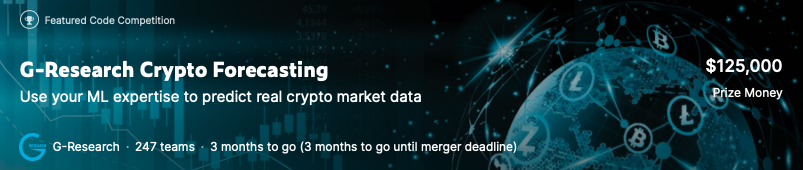

[The below data description copied from](https://www.kaggle.com/c/g-research-crypto-forecasting/data)

#  DATA DESCRIPTION

# Files

### train.csv - The training set

* timestamp - A timestamp for the minute covered by the row.
* Asset_ID - An ID code for the cryptoasset.
* Count - The number of trades that took place this minute.
* Open - The USD price at the beginning of the minute.
* High - The highest USD price during the minute.
* Low - The lowest USD price during the minute.
* Close - The USD price at the end of the minute.
* Volume - The number of cryptoasset units traded during the minute.
* VWAP - The volume weighted average price for the minute.
* Target - 15 minute residualized returns. See the 'Prediction and Evaluation' section of this notebook for details of how the target is calculated.



##### example_test.csv - An example of the data that will be delivered by the time series API.
##### example_sample_submission.csv - An example of the data that will be delivered by the time series API. The data is just copied from train.csv.
##### asset_details.csv - Provides the real name and of the cryptoasset for each Asset_ID and the weight each cryptoasset receives in the metric.
##### gresearch_crypto - An unoptimized version of the time series API files for offline work. You may need Python 3.7 and a Linux environment to run it without errors.
##### supplemental_train.csv - After the submission period is over this file's data will be replaced with cryptoasset prices from the submission period. The current copy, which is just filled approximately the right amount of data from train.csv is provided as a placeholder.

In [ ]:
!pip -q install mplfinance
import mplfinance as mpf

In [ ]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import datetime as dt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
pd.set_option('max_columns', 50)

plt.style.use('dark_background')

color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [ ]:
train_df = pd.read_csv('../input/g-research-crypto-forecasting/train.csv')
asset_df = pd.read_csv('../input/g-research-crypto-forecasting/asset_details.csv')
supplement_train_df = pd.read_csv('../input/g-research-crypto-forecasting/supplemental_train.csv')

In [ ]:
print (train_df.shape)
print (asset_df.shape)
print (supplement_train_df.shape)

In [ ]:
asset_df.head(15)

In [ ]:
asset_df['wgt_pct'] = asset_df['Weight'] /asset_df['Weight'].sum()*100

In [ ]:
explode = [0, 0, 0, 0, 0,0,0,0, 0,0,0,0.08,0.15, 0.18]

def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d} g)".format(pct, absolute)


ax = asset_df.set_index('Asset_Name')['wgt_pct'] \
    .sort_values(ascending=False) \
    .plot(kind='pie',
          figsize=(22, 12),
          fontsize = 14,
          textprops={'color':"magenta"}, 
           autopct='%0.2f%%',
          explode = explode,
          shadow = True,
          startangle=90, 
         )
ax.legend(asset_df['Asset_Name'],
          loc ="upper right",
          fontsize = 14,
          bbox_to_anchor =(1, 0, 0.5, 1))


ax.set_title('Assets by Weight Percentage\n\n ', fontsize=20, color = 'cyan')
ax.set_ylabel('')
plt.show()

In [ ]:
id_mapping = dict(asset_df[['Asset_ID', 'Asset_Name']].values)
wgt_mapping = dict(asset_df[['Asset_ID', 'Weight']].values)

In [ ]:
train_df["Asset name"] = train_df["Asset_ID"].map(id_mapping)
train_df["Asset weight"] = train_df["Asset_ID"].map(wgt_mapping)

In [ ]:
train_df.head()

**Correlation**

In [ ]:
corr = train_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
#with sns.axes_style("darkgrid"):
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(corr,mask=mask, annot = True, cmap = 'PiYG')


# Query only ethereum for the analysis

In [ ]:
ethereum = train_df.query("Asset_ID == 6").reset_index(drop = True)
ethereum['date'] = pd.to_datetime(ethereum['timestamp'], unit='s')
ethereum = ethereum.set_index('date')

In [ ]:
ethereum.shape[0]

In [ ]:
ethereum[ethereum['Target'].isnull()]


In [ ]:
ethereum.index.min(), ethereum.index.max()

In [ ]:
mpf.plot(ethereum, type = 'renko')

In [ ]:
sample_ = ethereum.loc['2021-04-01 05:45:00':'2021-04-01 8:00:00']

In [ ]:
mpf.plot(sample_, # the dataframe containing the OHLC (Open, High, Low and Close) data
         type='candle', # use candlesticks 
         volume=True, # also show the volume
         mav=(10, 20), # use three different moving averages
         figratio=(3,1), # set the ratio of the figure
         style='yahoo',  # choose the yahoo style
         title='Single day - short time frame transactions ');

# Show Intra-day

In [ ]:
sample_1 = ethereum.loc['2021-09-02 05:45:00':'2021-09-02 07:00:00']

In [ ]:
mpf.plot(sample_1,type='line',mav=(5,15),volume=True)

# Two Consequetive Day Transactions

In [ ]:
iday = ethereum.loc['2020-11-05':'2020-11-06',:]

In [ ]:
mpf.plot(iday,type='line',volume=True, warn_too_much_data=50, mav=(25,50))

# Simple LSTM 

In [ ]:
#Drop null values
"""
analyse single asset 
"""
ethereum.dropna(axis = 0, inplace = True)
ethereum.shape

In [ ]:
ethereum.head(5)

In [ ]:
#ethereum[ethereum.index == '2021-01-01 00:01:00']

Lets find the yearwise transaction pattern for ethereum

In [ ]:

ethereum.reset_index()
ethereum = ethereum.set_index('timestamp')

In [ ]:
####https://www.kaggle.com/sami116/first-steps-crypto-forecasting
f = plt.figure(figsize = (10,6))

ax = f.add_subplot(111)
ax.set_facecolor('azure')
plt.plot(ethereum['Close'], c = 'darkviolet')
plt.axvline(x = 1514764860, label = 'Start of 2018', c = 'gray')
plt.axvline(x = 1546300860, label = 'Start of 2019', c = 'orange')
plt.axvline(x = 1577836860, label = 'Start of 2020', c = 'forestgreen')
plt.axvline(x = 1609459260, label = 'Start of 2021', c = 'crimson')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Ethereum Close')
plt.grid()
plt.title('Close price of ethereum')

plt.show()

Its good to take 2021 data for prediction as compared to previous years 

# **[The below model is taken from the case study , ](https://thinkingneuron.com/predicting-stock-prices-using-deep-learning-lstm-model-in-python/)**

# Preparing the data

In [ ]:
ethereum.head()

In [ ]:
ethereum.reset_index(inplace = True)
ethereum['date'] = pd.to_datetime(ethereum['timestamp'], unit='s')
ethereum = ethereum.set_index('date')
ethereum.head()

In [ ]:
FullData = ethereum.loc['2021-05-01 00:01:00':'2021-06-30 23:59:59']
FullData.head()

In [ ]:

# Extracting the closing prices of each day
FullData=FullData[['Target']].values 
                  #ethereum[:25000][['Target']].values
print(FullData[0:5])
 
# Feature Scaling for fast training of neural networks
from sklearn.preprocessing import StandardScaler, MinMaxScaler
 
# Choosing between Standardization or normalization
#sc = StandardScaler()
sc=MinMaxScaler()
 
DataScaler = sc.fit(FullData)
X=DataScaler.transform(FullData)
#X=FullData
 
print('### After Normalization ###')
X[0:5]

# Prepare LSTM inputs

In [ ]:
# split into samples
X_samples = list()
y_samples = list()

NumerOfRows = len(X)
TimeSteps=15  # next day's Price Prediction is based on last how many past day's prices

# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)

################################################
# Reshape the Input as a 3D (number of samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('\n#### Input Data shape ####')
print(X_data.shape)

# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0], 1)
print('\n#### Output Data shape ####')
print(y_data.shape)

# Train Test Split

In [ ]:
# Choosing the number of validation data records
TestingRecords=500
 
# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]
 
############################################
 
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n#### Validation Data shape ####')
print(X_test.shape)
print(y_test.shape)

# Visualize the input output data for LSTM

In [ ]:

# Visualizing the input and output being sent to the LSTM model
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp,'--', out)

In [ ]:

# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

#### some of the important hyperparameters of LSTM 

1. **units=15**: This means we are creating a layer with fifteen neurons in it. Each of these fifteen neurons will be receiving the values of inputs.
1. **input_shape = (TimeSteps, TotalFeatures):** The input expected by LSTM is in 3D format. Our training data has a shape of (24470, 30, 1) this is in the form of (number of samples, time steps, number of features). This means we have 25000 examples to learn in training data, each example looks back 30-steps in time like what was the asset price yesterday, the day before yesterday so on till last 30 days. This is known as Time steps. The last number ‘1’ represents the number of features. Here we are using just one column ‘Target’ hence its equal to ‘1’
1. **kernel_initializer=’uniform’:** When the Neurons start their computation, some algorithm has to decide the value for each weight. This parameter specifies that. You can choose different values for it like ‘normal’ or ‘glorot_uniform’.
1. **activation=’relu’:** This specifies the activation function for the calculations inside each neuron. You can choose values like ‘relu’, ‘tanh’, ‘sigmoid’, etc.
1. **return_sequences=True:** LSTMs backpropagate thru time, hence they return the values of the output from each time step to the next hidden layer. This keeps the expected input of the next hidden layer in the 3D format. This parameter is False for the last hidden layer because now it does not have to return a 3D output to the final Dense layer.
1. **optimizer=’adam’: ** This parameter helps to find the optimum values of each weight in the neural network. ‘adam’ is one of the most used optimizers’
1. **batch_size=20:** This specifies how many rows will be passed to the Network.

1. **Epochs=5:**  The LSTM network looks at the full training data 5 times and adjusts its weights.

# Define LSTM Model

In [ ]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
 
# Initialising the RNN
regressor = Sequential()
 
# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 15, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Second Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Second Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
 
regressor.add(Dropout(0.3))
# Adding the output layer
regressor.add(Dense(units = 1))
 
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
##################################################
 
import time
# Measuring the time taken by the model to train
StartTime=time.time()
 
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 15, epochs = 3)
 
EndTime=time.time()
print("## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ##')

# Measuring the accuracy on validation data

In [ ]:

# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
 
# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)
 
# Accuracy of the predictions
#print('Accuracy:', 100 - (100*(abs(orig-predicted_Price)/orig)).mean())
 
# Visualising the results
import matplotlib.pyplot as plt
 
plt.plot(predicted_Price, color = 'pink', label = 'Predicted Volume')
plt.plot(orig, color = 'green', label = 'Original Volume')
 
plt.title('Predicting Ethereum ')
plt.xlabel(' Date')
plt.xticks(range(TestingRecords), ethereum.tail(TestingRecords)['Target'])
plt.ylabel(' Price')
 
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

# Visualizing the Full Data

In [ ]:
TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))
 
FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullData[TimeSteps:]
 
# plotting the full data
plt.plot(FullDataPredictions, color = 'magenta', label = 'Predicted Price')
plt.plot(FullDataOrig , color = 'lightblue', label = 'Original Price')
 
 
plt.title(' Price Predictions')
plt.xlabel(' Date')
plt.ylabel(' Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

In [ ]:
ethereum[['Target']].tail(51).values.flatten()

# With above model, we just predict one last value for ethereum

In [ ]:

# Last 10 days prices
Last50Days=np.array([ 0.00045282,  0.00061184,  0.0012775 ,  0.00086473,  0.00072952,
        0.00110401,  0.00171625,  0.00118262,  0.00100348,  0.00164157,
        0.0029463 ,  0.00314749,  0.00281155,  0.00217294,  0.00238924,
        0.00390146,  0.00361306,  0.0040886 ,  0.00405105,  0.00269954,
        0.00242405,  0.00102109,  0.00140944,  0.00131124,  0.00059185,
       -0.00050834,  0.0010392 ,  0.00123086,  0.00070894,  0.00061493,
       -0.00096887, -0.00127859, -0.00162916, -0.00223221, -0.00142235,
       -0.00225987, -0.00152843, -0.00087532, -0.00061999,  0.00025487,
        0.00057095, -0.00130277, -0.00127819, -0.00129005, -0.00076483,
       -0.00189372, -0.00130851, -0.0007357 , -0.00049116, -0.00056185
      ])
 
# Normalizing the data just like we did for training the model
Last50Days=DataScaler.transform(Last50Days.reshape(-1,1))
 
# Changing the shape of the data to 3D
# Choosing TimeSteps as 10 because we have used the same for training
NumSamples=1
TimeSteps=50
NumFeatures=1
Last50Days=Last50Days.reshape(NumSamples,TimeSteps,NumFeatures)
 
#############################
 
# Making predictions on data
predicted_Price = regressor.predict(Last50Days)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
predicted_Price

**Model has predicted -0.00062102 whereas actual target value is -0.0003459, the prediction is not accurate, But, we can improve the model performance....**

# MultiStep Time Series

**Assume We need to predict next 15 days price from the last 50 days values**

# Data Preparation for Multi Step LSTM

In [ ]:

# Considering the Full Data again which we extracted above
# Printing the last 10 values
print('Original Prices')
print(FullData[-10:])
 
print('###################')
 
# Printing last 10 values of the scaled data which we have created above for the last model
# Here I am changing the shape of the data to one dimensional array because
# for Multi step data preparation we need to X input in this fashion
X=X.reshape(X.shape[0],)
print('Scaled Prices')
print(X[-10:])

In [ ]:

# Multi step data preparation
 
# split into samples
X_samples = list()
y_samples = list()
 
NumerOfRows = len(X)
TimeSteps=50  # next few day's Price Prediction is based on last how many past day's prices
FutureTimeSteps=15 # How many days in future you want to predict the prices
 
# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows-FutureTimeSteps , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i:i+FutureTimeSteps]
    X_samples.append(x_sample)
    y_samples.append(y_sample)
    
# Reshape the Input as a 3D (samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('### Input Data Shape ###') 
print(X_data.shape)
 
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
print('### Output Data Shape ###') 
print(y_data.shape)

Note **FutureTimeSteps** will be the number of days prices to be predicted

# Train Test Split

In [ ]:

# Choosing the number of testing data records
TestingRecords=5
 
# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]
 
#############################################
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
 
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)

# Visualizing the input->output sent to LSTM Multi-step model

In [ ]:

# Visualizing the input and output being sent to the LSTM model
# Based on last 10 days prices we are learning the next 5 days of prices
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp)
    print('====>')
    print(out)
    print('#'*20)

In [ ]:

# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

# Define Multi Step LSTM model

In [ ]:
# Initialising the RNN
regressor = Sequential()
 
# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
 
# Adding the Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
 
regressor.add(Dropout(0.25))
# Adding the output layer
# Notice the number of neurons in the dense layer is now the number of future time steps 
# Based on the number of future days we want to predict
regressor.add(Dense(units = FutureTimeSteps))
 
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
###################################################################
 
import time
# Measuring the time taken by the model to train
StartTime=time.time()
 
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 15, epochs = 3)
 
EndTime=time.time()
print("############### Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes #############')


# Measuring the Accuracy of the model on validation data

In [ ]:
#Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
print('#### Predicted Prices ####')
print(predicted_Price)
 
# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)
print('\n#### Original Prices ####')
print(orig)

In [ ]:
 
for i in range(len(orig)):
    Prediction=predicted_Price[i]
    Original=orig[i]
     
    # Visualising the results
    plt.plot(Prediction, color = 'brown', label = 'Predicted Volume')
    plt.plot(Original, color = 'lightblue', label = 'Original Volume')
 
    plt.title('### Accuracy of the predictions:'+ str(100 - (100*(abs(Original-Prediction)/Original)).mean().round(2))+'% ###')
    plt.xlabel(' Date')
    
    startDateIndex=(FutureTimeSteps*TestingRecords)-FutureTimeSteps*(i+1)
    endDateIndex=(FutureTimeSteps*TestingRecords)-FutureTimeSteps*(i+1) + FutureTimeSteps
    TotalRows=ethereum.shape[0]
 
    plt.xticks(range(FutureTimeSteps), ethereum.iloc[TotalRows-endDateIndex : TotalRows-(startDateIndex) , :]['Target'])
    plt.ylabel(' Price')
 
    plt.legend()
    fig=plt.gcf()
    fig.set_figwidth(20)
    fig.set_figheight(3)
    plt.show()

# Making Prediction for next 15 days

In [ ]:
ethereum[['Target']].tail(65).values.flatten()

In [ ]:

# Making predictions on test data
Last50DaysPrices=np.array([-0.00480228, -0.0048188 , -0.00373259, -0.00228633, -0.00241039,
       -0.00222162, -0.00076806, -0.00089731, -0.00111598, -0.00050295,
       -0.00094476, -0.00030015,  0.00144354,  0.00243018,  0.00045282,
        0.00061184,  0.0012775 ,  0.00086473,  0.00072952,  0.00110401,
        0.00171625,  0.00118262,  0.00100348,  0.00164157,  0.0029463 ,
        0.00314749,  0.00281155,  0.00217294,  0.00238924,  0.00390146,
        0.00361306,  0.0040886 ,  0.00405105,  0.00269954,  0.00242405,
        0.00102109,  0.00140944,  0.00131124,  0.00059185, -0.00050834,
        0.0010392 ,  0.00123086,  0.00070894,  0.00061493, -0.00096887,
       -0.00127859, -0.00162916, -0.00223221, -0.00142235, -0.00225987])
 
# Reshaping the data to (-1,1 )because its a single entry
Last50DaysPrices=Last50DaysPrices.reshape(-1, 1)
 
# Scaling the data on the same level on which model was trained
X_test=DataScaler.transform(Last50DaysPrices)
 
NumberofSamples=1
TimeSteps=X_test.shape[0]
NumberofFeatures=X_test.shape[1]
# Reshaping the data as 3D input
X_test=X_test.reshape(NumberofSamples,TimeSteps,NumberofFeatures)
 
# Generating the predictions for next 5 days
Next15DaysPrice = regressor.predict(X_test)
 
# Generating the prices in original scale
Next15DaysPrice = DataScaler.inverse_transform(Next15DaysPrice)
Next15DaysPrice

I have taken single asset *Ethereum* here for demo purpose, the competition requires all 14 assets to be predicted..

Thank you for reading

**Few graph ideas are taken from the below beautiful kernels.**

https://www.kaggle.com/robikscube/predict-crypto-prices-twitch-stream

https://www.kaggle.com/carlmcbrideellis/g-research-plot-financial-data-using-mplfinance/notebook

https://www.kaggle.com/sami116/first-steps-crypto-forecasting/notebook